In [1]:
###LOAD IN THE DATA AND RELEVANT PYTHON PACKAGES###

import pandas as pd
import numpy as np
import cmlreaders as cml
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

exp = 'ltpFR2'
df = cml.get_data_index('ltp', rootdir='/').query('experiment == @exp')

#load in ltpFR2 (PEERS4)
#ltpFR2_df = df.query('experiment == "ltpFR2"')
df['subject'].unique()
len(df['subject'].unique()) #indicates there are 127 subjects

Subj = df['subject'].unique()
nSubj = len(Subj)


###Use this code to restrict to subjects who completed all 24 sessions

GoodSubj = [True]*len(Subj)
for i in range(0, len(Subj)):
    df_select = df[(df['subject']==Subj[i]) & (df['experiment']==exp)]
    if len(df_select) < 18:
        GoodSubj[i] = False

Subj = Subj[GoodSubj]
nSubj = len(Subj)
print(nSubj)


97


In [2]:
###GET THE DATA FROM ALL SUBJECTS, IF THE DATA IS LOADABLE###

exp = 'ltpFR2'

Subj = df['subject'].unique()
nSubj = len(Subj)

#Instantiate a CML Raader for each session per subject
def get_behav_data(subject, experiment, session):
    reader = cml.CMLReader(subject=subject, experiment=experiment, session=session).load('task_events')
    return reader


SP1 = []

#Identify if each subject has data stored, and if so, add it to SP1 using get_behav_data function
for i in range(nSubj):
    subject = Subj[i]
    df_select = df[(df['subject']==subject) & (df['experiment']==exp)]
    sessions = df_select['session'].unique()  # Get unique sessions for this subject
    for session in sessions:
        try:
            behav_data = get_behav_data(subject, exp, session)
            SP1.append(behav_data)
        except FileNotFoundError:
            print(f"Data not found for subject {subject}, session {session}. Skipping...")
            # Remove instances where FileNotFound
        except Exception as e:
            print(f"An unexpected error occurred for subject {subject}, session {session}: {e}. Skipping...")
            # Remove instances where other errors occurred in loading the data

#Concatenate to df          
all_df = pd.concat(SP1)
len(all_df)


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:250: UserWarning: Changing events session field from -999 to 10 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +


An unexpected error occurred for subject LTP326, session 19: Events DataFrame is empty. Events JSON or MATLAB                 file likely empty, and experiment session likely not run or uploaded properly.. Skipping...


2341277

In [241]:
#Save to CSV file for easy loading
all_df.to_csv("IRT_data.csv") 
data = pd.read_csv("IRT_data.csv") #comment out the above line and load in the data this way to skip the previous steps

In [242]:
#Inspect the data

len(data.subject.unique()) #how many subjects?

#We need to drop the 24th session because it uses a different format than sessions 1 through 23 
data2 = data[data['session'] < 23] 
len(data2.session.unique()) #23 sessions, good!

23

In [245]:
###EXTRACT DIFFERENT EVENT DATAFRAMES FROM THE GLOBAL DATAFRAME###

#encoding events
word_evs = data2[data2['type']=='WORD']
#word_evs[:10]

#retrieval events
rec_evs = data2[data2['type']=='REC_WORD']
#rec_evs[:10]

rec_evs.columns #intrusion to code for whether the recalled word is an intrusion
#rectime will be the time since start of the recall period

#There are a lot of columns that make looking at the data a headache. Just keeping the ones necessary:

columns_to_keep = ['intrusion', 'item_name', 'item_num', 'rectime', 'serialpos', 'session',
                  'subject', 'trial']
rec_evs2 = rec_evs[columns_to_keep]
rec_evs2[:10]

,intrusion,item_name,item_num,rectime,serialpos,session,subject,trial
27,0,BALLOON,75,1014,1,0,LTP093,1
28,0,MAILBOX,857,1711,2,0,LTP093,1
29,0,FLOWER,584,2679,3,0,LTP093,1
30,0,DAUGHTER,442,3811,4,0,LTP093,1
31,0,BLUEPRINT,142,5559,5,0,LTP093,1
32,0,TRACTOR,1493,6242,6,0,LTP093,1
33,0,SCALPEL,1243,7089,7,0,LTP093,1
34,0,IGLOO,734,9348,23,0,LTP093,1
35,0,CANAL,226,9957,20,0,LTP093,1
36,0,MUSTARD,935,10704,13,0,LTP093,1


In [244]:
#check if there are NaN values in rectime; if so, we must remove these rows
nan_values = rec_evs2['rectime'].isna().sum()

if nan_values > 0:
    print(f"There are {nan_values} NaN values in the 'rectime' column.")
else:
    print("There are no NaN values in the 'rectime' column.")

There are no NaN values in the 'rectime' column.


In [246]:
###FILTER OUT INTRUSIONS###

#Drop intrusions (PLIs and ELIs) and all recalls after an instrusion is made
#We will only analyze IRTs for uninterrupted series of correct recalls
#If the intrusion value is anything but 0, the recall was an intrusion
#Here, we sorted out all rows where the cumulative intrusion value exceeds 1
#Later, in "Coding_Predictors," we caught a mistake and also removed negative intrusion values.

rec_evs2_sorted = rec_evs2.sort_values(by=['subject', 'session', 'trial'])

# Group by subject, session, and trial, then create a cumulative sum of intrusion
rec_evs2_sorted['cumsum_intrusion'] = rec_evs2_sorted.groupby(['subject', 'session', 'trial'])['intrusion'].cumsum()

# Filter out the rows where the first non-zero intrusion occurs
filtered_rec_evs2 = rec_evs2_sorted[rec_evs2_sorted['cumsum_intrusion'] <= 1]

# Drop the 'cumsum_intrusion' column if you don't need it anymore
filtered_rec_evs2.drop(columns='cumsum_intrusion', inplace=True)
#print("Number of rows:", filtered_rec_evs2.shape[0]) 658523 observations 

#Also drop all repeat recalls (if an item was already recalled in a list, remove its second occurrence)
#drop all repeat serial positions (same word recalled multiple times) for each list/trial per session
#per subject; create a new dateframe that retains only the first recall of a given word

new_df = filtered_rec_evs2[~filtered_rec_evs2.duplicated(subset=['subject', 'session', 'trial', 'serialpos'], keep='first')].copy()
new_df.head()

/tmp/ipykernel_91476/3349875378.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rec_evs2.drop(columns='cumsum_intrusion', inplace=True)


,intrusion,item_name,item_num,rectime,serialpos,session,subject,trial
27,0,BALLOON,75,1014,1,0,LTP093,1
28,0,MAILBOX,857,1711,2,0,LTP093,1
29,0,FLOWER,584,2679,3,0,LTP093,1
30,0,DAUGHTER,442,3811,4,0,LTP093,1
31,0,BLUEPRINT,142,5559,5,0,LTP093,1


In [248]:
###Now let's add in the output position of each recall in each list (trial in new_df) ###

# Sort the DataFrame by subject, session, trial, and rectime
new_df.sort_values(by=['subject', 'session', 'trial', 'rectime'], inplace=True)

# Add a new variable 'Output' to code for the output position in the recall list
new_df['OutputPosition'] = new_df.groupby(['subject', 'session', 'trial']).cumcount() + 1
#add +1 because of counting starts at 0 in Python

# Print the DataFrame to verify the results
#new_df[:20]

In [249]:
###CREATE IRTS####

##First, let's count up the total_recall per list##

# Count up the number of recalls per list (trial)
new_df['total_recall'] = new_df.groupby(['subject', 'session', 'trial'])['OutputPosition'].transform('count')


##Now let's create IRTs as the difference in rectime between successive recalls in a list (i.e., trial in new_df)##

# Sort the DataFrame by subject, session, trial, and rectime
new_df.sort_values(by=['subject', 'session', 'trial', 'rectime'], inplace=True)

# Calculate the inter-response times (IRT) within each trial
new_df['IRT'] = new_df.groupby(['subject', 'session', 'trial'])['rectime'].diff()

# Identify the first recall event where IRT is NaN
first_nan_index = new_df[new_df['IRT'].isna()].groupby(['subject', 'session', 'trial']).head(1).index

# Exclude the first NaN IRT and renumber the OutputPosition variable starting from the second recall
new_df.loc[first_nan_index, 'OutputPosition'] = pd.NA
new_df['OutputPosition'] = new_df.groupby(['subject', 'session', 'trial'])['OutputPosition'].transform(lambda x: pd.Series(range(len(x)), index=x.index))

# Drop rows where OutputPosition is NaN
new_df.dropna(subset=['OutputPosition'], inplace=True)

# Convert IRT to ms
new_df['IRT'] = new_df['IRT'] / 1000  

# Display the DataFrame with renumbered OutputPosition and IRT
new_df[:20]

,intrusion,item_name,item_num,rectime,serialpos,session,subject,trial,IRT,OutputPosition,IRT2,total_recall
27,0,BALLOON,75,1014,1,0,LTP093,1,NaN,0,1.014,17
28,0,MAILBOX,857,1711,2,0,LTP093,1,0.697,1,0.697,17
29,0,FLOWER,584,2679,3,0,LTP093,1,0.968,2,0.968,17
30,0,DAUGHTER,442,3811,4,0,LTP093,1,1.132,3,1.132,17
31,0,BLUEPRINT,142,5559,5,0,LTP093,1,1.748,4,1.748,17
32,0,TRACTOR,1493,6242,6,0,LTP093,1,0.683,5,0.683,17
33,0,SCALPEL,1243,7089,7,0,LTP093,1,0.847,6,0.847,17
34,0,IGLOO,734,9348,23,0,LTP093,1,2.259,7,2.259,17
35,0,CANAL,226,9957,20,0,LTP093,1,0.609,8,0.609,17
36,0,MUSTARD,935,10704,13,0,LTP093,1,0.747,9,0.747,17


In [253]:
###CREATE LAGS FOR LAG-CRL PLOT###

# Sort the DataFrame by subject, session, trial, and rectime
new_df.sort_values(by=['subject', 'session', 'trial', 'rectime'], inplace=True)

# Compute the lag variable within each trial where IRT is not NaN
new_df['lag'] = new_df.groupby(['subject', 'session', 'trial'])['serialpos'].diff().where(~new_df['IRT'].isna())

# Display the DataFrame with the lag variable
#new_df[:20]

Mean of the values in w2v_data: 0.10582360781530467
Standard deviation of the values in w2v_data: 0.09274841462974803
Minimum value in w2v_data: -0.17652910929102283


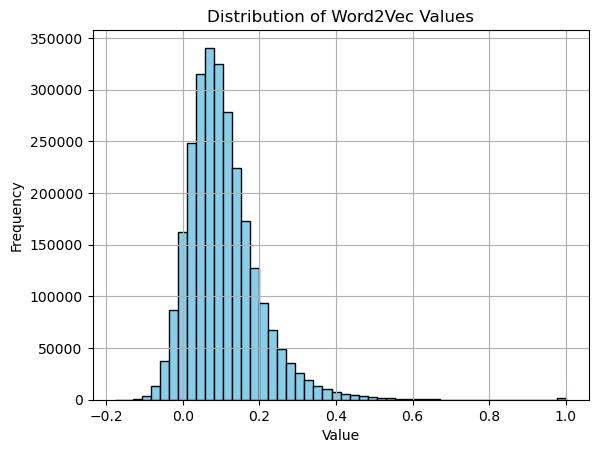

In [255]:
####WORD2VEC SIMILARITIES####

def get_w2v():
    import scipy.io as sio
    import os
    file_path = os.path.join(os.getcwd(), 'w2v.mat')
    return sio.loadmat(file_path)['w2v']

w2v_data = get_w2v()

#print(w2v_data)
#print("Shape of w2v_data:", w2v_data.shape) #1638 x 1638, so each entry is a word in the wordpool

# Calculate the mean of the values in w2v_data
mean_value = np.mean(w2v_data)

# Calculate the standard deviation of the values in w2v_data
std_deviation = np.std(w2v_data)

#minv = np.min(w2v_data)
#maxv = np.max(w2v_data)

# Print the mean and standard deviation
print("Mean of the values in w2v_data:", mean_value)
print("Standard deviation of the values in w2v_data:", std_deviation)
print("Minimum value in w2v_data:", minv)
#print("Maximum value in w2v_data:", maxv)

###CREATE A HISTOGRAM OF W2V VALUES

# Flatten the w2v_data matrix into a 1D array
values = w2v_data.flatten()

# Plot the distribution of values
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Word2Vec Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [262]:
import scipy.io as sio

# Load the entire contents of the MATLAB file into a dictionary
mat_contents = sio.loadmat('w2v.mat')
order_contents = sio.loadmat('WordOrder.mat') #find what each row and column value in w2v.mat corresponds to

order = order_contents['WordOrder']

#print("Keys in the MATLAB file:", mat_contents.keys())
#print("Keys in the MATLAB file:", order_contents.keys())
#print("Shape of w2v_data:", order.shape)
#print(order_contents['WordOrder'])
print(order)

#Extracting just the words
words = order.flatten()

# Convert the numpy array of dtype '<Ux' to a list of strings
words = [word.item() for word in words]

#print(words)

###A SANITY CHECK TO SEE IF TWO SEEMINGLY RELATED WORDS HAVE A HIGH SIMILARITY RATING####
#Recall the mean = 0.10, and SD = 0.09, so we would expect these similar words to have a rating many SDs above the mean

# Find the position of the word "BLADE" and "SCALPEL" in the list
position_blade = words.index('BLADE')
position_scalpel = words.index('SCALPEL')
position_abdomen = words.index('ABDOMEN') #including just to confirm the list is 0-indexed, and as a control

# Print the positions
#print("Position of 'BLADE' in the list:", position_blade) #133
#print("Position of 'SCALPEL' in the list:", position_scalpel) #1242
#print("Position of 'ABDOMEN' in the list:", position_abdomen) #0

entry = w2v_data[133, 1242] 
print(entry) #0.3669 similarity between BLADE and SCALPEL

entry2 = w2v_data[0, 1242]
print(entry2) #0.333 similarity between ABDOMEN AND SCALPEL

###NOW CONVERT W2V INTO A DATAFRAME AND ADD THE WORDS AS ROW AND COLUMN HEADERS###

# Convert the w2v_data matrix to a DataFrame
df_w2v = pd.DataFrame(w2v_data)

# Insert a new row at the beginning with the words as column headers
df_w2v.columns = words

# Insert a new column at the beginning with the words as the first column
df_w2v.insert(0, 'Words', words)

# Display the DataFrame
#print(df_w2v)
#df_w2v[:20]

[[array(['ABDOMEN'], dtype='<U7') array(['ACID'], dtype='<U4')
  array(['ACORN'], dtype='<U5') ... array(['ZIPPER'], dtype='<U6')
  array(['ZOO'], dtype='<U3') array(['ZUCCHINI'], dtype='<U8')]]
0.3669387202862583
0.33367463819791904
'JOURNALIST' is not present in df_w2v.


In [263]:
####HERE WE LOOK UP THE SIMILARITY VALUES BETWEEN EACH PAIR OF WORDS AND PASS THESE 
##INTO NEW_DF AS A NEW VARIABLE THAT LISTS THE SIMILARITY OF ITEM 1+1 RELATIVE TO ITEM 1
##CODE CAN TAKE A BIT OF TIME TO RUN, SO IN THE NEXT CODE BLOCK WE SAVE THIS TO A NEW .CSV AND LOAD THAT IN LATER

# Function to look up similarity value from df_w2v
def lookup_similarity(word1, word2, df_w2v):
    try:
        # Look up similarity value between word1 and word2 in df_w2v
        similarity = df_w2v.loc[df_w2v['Words'] == word1, word2].iloc[0]
        return similarity
    except (IndexError, KeyError):
        # Handle if one of the words is not found in df_w2v
        return None

# Initialize list to store semantic similarity values
semantic_sims = []

# Iterate over rows of new_df DataFrame
for i in range(1, len(new_df)):
    # Get words for current and previous trials
    word1 = new_df['item_name'].iloc[i - 1]
    word2 = new_df['item_name'].iloc[i]
    
    # Look up similarity value from df_w2v
    similarity = lookup_similarity(word1, word2, df_w2v)
    
    # Append similarity value to list if it's not None
    if similarity is not None:
        semantic_sims.append(similarity)
    else:
        # If similarity is None, append None and continue
        semantic_sims.append(None)

# Add SemanticSim column to new_df DataFrame
new_df['SemanticSim'] = [None] + semantic_sims  # Pad with None for the first trial

In [265]:
###Create a save point to avoid having to run the above code again###
#new_df.to_csv("IRT_data_updated.csv")
new_df = pd.read_csv("IRT_data_updated.csv") #load in the updated data file with semantic similarity values

In [266]:
# Set SemanticSim to NaN where IRT is NaN (start of new trials)
new_df.loc[new_df['IRT'].isna(), 'SemanticSim'] = np.nan
#new_df[:20]

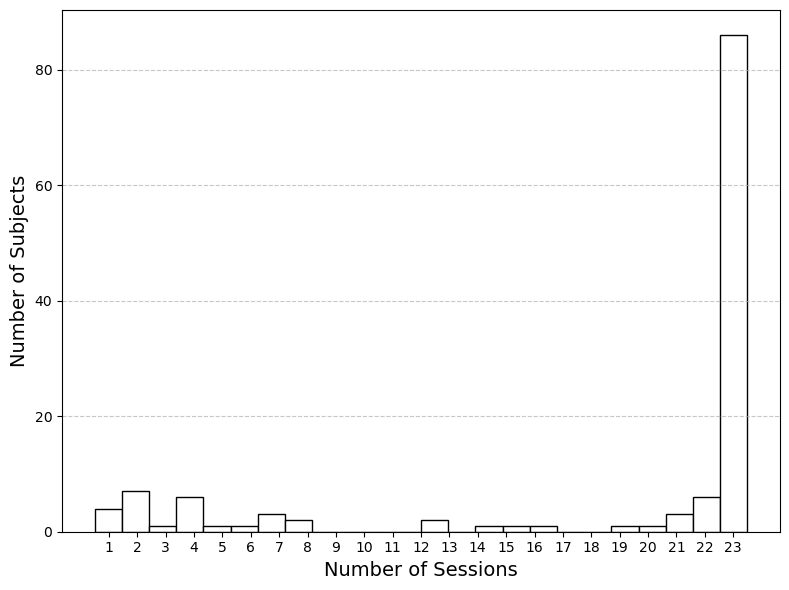

In [272]:
###Get some information about sessions completed by subject###
session_counts = new_df.groupby('subject')['session'].nunique()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(session_counts, bins=max(session_counts) - min(session_counts) + 2, range=(min(session_counts) - 0.5, max(session_counts) + 0.5), align='mid', color='white', edgecolor='black')

# Customize the plot
plt.xlabel('Number of Sessions', fontsize=14)
plt.ylabel('Number of Subjects', fontsize=14)
#plt.title('Distribution of Number of Sessions Completed', fontsize=16)
plt.xticks(range(min(session_counts), max(session_counts) + 1))

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [275]:
# 1. Calculate the average number of sessions completed by all subjects
average_sessions = new_df.groupby('subject')['session'].nunique().mean()

# 2. Calculate the standard deviation of the number of sessions completed by all subjects
std_dev_sessions = new_df.groupby('subject')['session'].nunique().std()

# 3. Calculate the range (minimum to maximum) of the number of sessions completed across subjects
min_sessions = new_df.groupby('subject')['session'].nunique().min()
max_sessions = new_df.groupby('subject')['session'].nunique().max()
#session_range = max_sessions - min_sessions

# Print the results
print("Average number of sessions completed by all subjects:", average_sessions)
print("Standard deviation of the number of sessions completed by all subjects:", std_dev_sessions)
print("Minimum number of sessions completed:", min_sessions)

Average number of sessions completed by all subjects: 18.69291338582677
Standard deviation of the number of sessions completed by all subjects: 7.737264816564365
Minimum number of sessions completed: 1
